In [5]:
import matplotlib.pyplot as plt
%matplotlib notebook
from NilsPodLib import session as sensor
import tkinter as tk
from tkinter import filedialog
import numpy as np
import scipy.signal
import pandas as pd

def movingaverage (values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'same')
    return sma


def markArea(ax, color , values, idx):
    ax.axvspan(values[idx[0]],values[idx[1]], facecolor = color, alpha = 0.1)
    for i in range(1,len(idx)-2):
        ax.axvspan(values[idx[i]+1],values[idx[i+1]], facecolor = color, alpha = 0.1) 
        
def millibar2Meter(baro_millibar):
    altitude = np.copy(baro_millibar)
    for i in range(0,len(altitude)):
        altitude[i] = 44330 * (1.0 - pow(baro_smooth[i] / seaLevelhPa, 0.1903));
    return altitude;



In [6]:

file_path = '/Users/nils/Desktop/NilsPodX-3F7F_20190405_1346.bin'
#file_path = '/Users/nils/Desktop/NilsPodX-5CF4_20190405_1344.bin'

dataset = sensor.Dataset(file_path)
baro_data = dataset.baro.data #eliminate first few baro samples as they often read wrong values
baro_data[0:5] = dataset.baro.data[5]
gyro_data = dataset.gyro.data
acc_data = dataset.acc.data

Header Size = 29
old firmware format
old firmware format


In [7]:
baro_smooth = scipy.signal.savgol_filter(baro_data, window_length=1201, polyorder=5)
baro_smooth_avg = movingaverage(baro_smooth,4000);


baro_grad = np.gradient(baro_smooth)   
baro_grad_smooth = movingaverage(baro_grad,5000);
baro_grad_threshold = np.std(baro_grad_smooth)/10;


ride = np.where(baro_grad_smooth > baro_grad_threshold)[0]
idx_ride = np.where(np.diff(ride) > 1)
idx_ride = np.insert(idx_ride, 0, 0, axis=1)[0]

no_ride = np.where(baro_grad_smooth < -baro_grad_threshold)[0]
idx_no_ride = np.where(np.diff(no_ride) > 1)
idx_no_ride = np.insert(idx_no_ride, 0, 0, axis=1)[0]

<IPython.core.display.Javascript object>


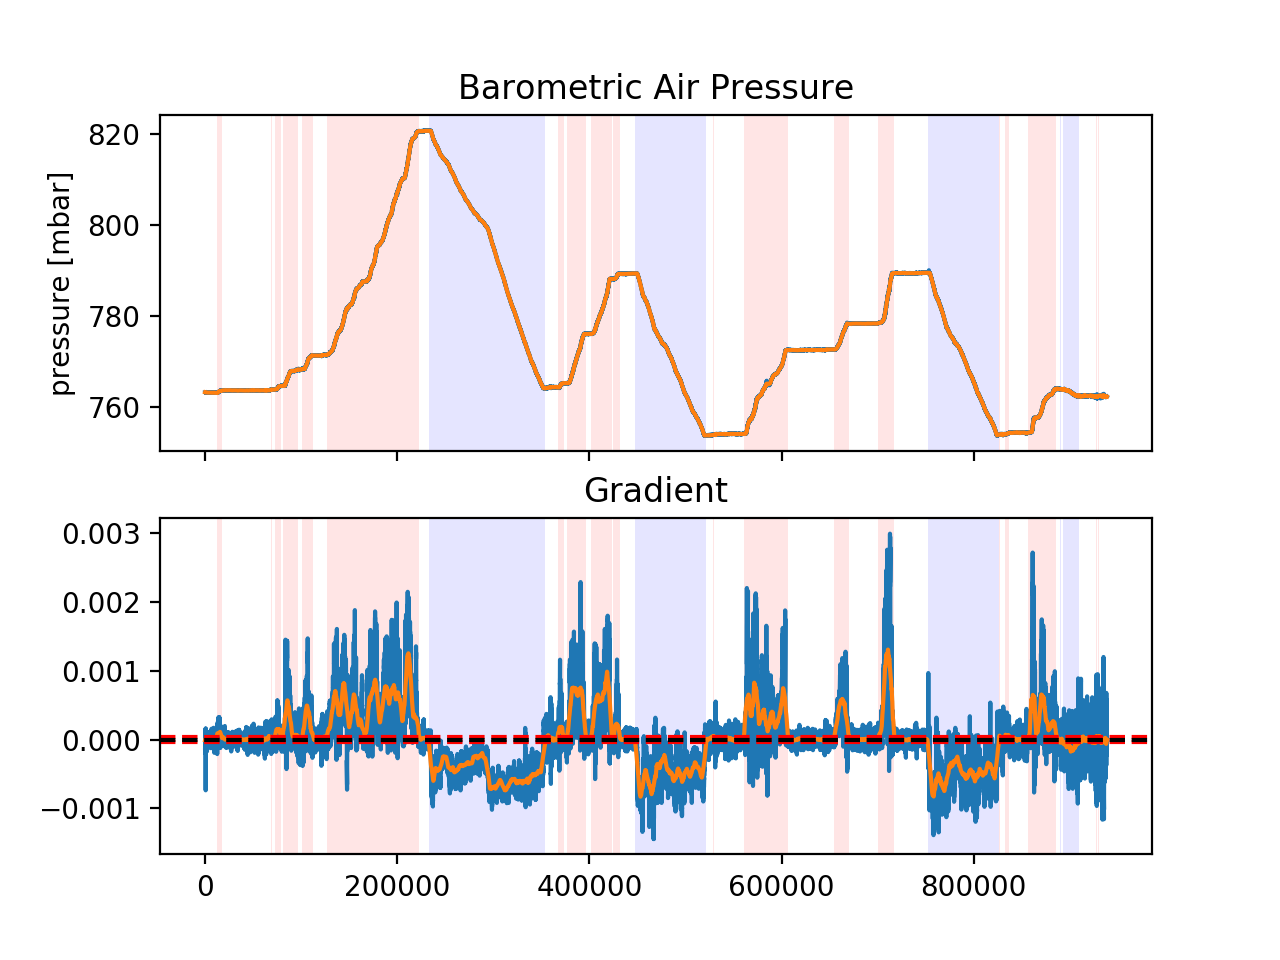

In [11]:
f, axarr = plt.subplots(2,sharex=True)
axarr[0].plot(baro_data)
axarr[0].plot(baro_smooth)
axarr[0].set_ylabel('pressure [mbar]')
axarr[0].set_title('Barometric Air Pressure')

axarr[1].plot(baro_grad)
axarr[1].plot(baro_grad_smooth)
axarr[1].set_title('Gradient')
axarr[1].axhline(y=baro_grad_threshold, color='r', linestyle='--')
axarr[1].axhline(y=-baro_grad_threshold, color='r', linestyle='--')
axarr[1].axhline(y=0.0, color='k', linestyle='--')
markArea(axarr[0], 'r', ride, idx_ride)
markArea(axarr[0], 'b', no_ride, idx_no_ride)
markArea(axarr[1], 'r', ride, idx_ride)
markArea(axarr[1], 'b', no_ride, idx_no_ride)
f.show();

In [12]:
min_ride_length_seconds = 30
min_lift_length_seconds = 120

seaLevelhPa = 1013.0
altitude = millibar2Meter(baro_smooth)

# cut rides from altitude
rides = list();
start = ride[idx_ride[0]]
stop = ride[idx_ride[1]]
rides.append(altitude[start:stop])
for i in range(1,len(idx_ride)-2):
    start = ride[idx_ride[i]+1]
    stop = ride[idx_ride[i+1]]
    if(stop-start > min_ride_length_seconds*204.8):
        rides.append(altitude[start:stop])

# cut lift events from altitude
lifts = list();
start = no_ride[idx_no_ride[0]]
stop = no_ride[idx_no_ride[1]]
lifts.append(altitude[start:stop])
for i in range(1,len(idx_no_ride)-2):
    start = no_ride[idx_no_ride[i]+1]
    stop = no_ride[idx_no_ride[i+1]]
    if(stop-start > min_lift_length_seconds*204.8):
        lifts.append(altitude[start:stop])
    
lift_time = 0    
for lift_ride in lifts:
    lift_time = lift_time + len(lift_ride)

ride_time = 0    
for ride_ride in rides:
    ride_time = ride_time + len(ride_ride)
    
    
vertical_velocity = list();
max_vertical_velocity = list();
for r in rides:
    vertical_velocity.append(np.diff(r))
    
vertical_velocity_smooth = list()

for vel in vertical_velocity:
    v = movingaverage(vel,4000);
    v = v/(1/204.8)
    vertical_velocity_smooth.append(v)
    max_vertical_velocity.append(np.min(v))
   
    

In [22]:
print("Total Movement Time: " + "{0:.2f}".format((lift_time/204.8/60)+(ride_time/204.8/60)) + " min")
print("Lift Time (min): " + "{0:.2f}".format(lift_time/204.8/60))
print("Lift Time (%) " + "{0:.2f}".format((lift_time/(lift_time+ride_time))))
print("Ride Time (min): " + "{0:.2f}".format(ride_time/204.8/60))
print("Ride Time (%) " + "{0:.2f}".format(ride_time/(lift_time+ride_time)))

Total Movement Time: 45.66 min
Lift Time (min): 21.90
Lift Time (%) 0.48
Ride Time (min): 23.76
Ride Time (%) 0.52


In [14]:
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure,output_notebook, show
from bokeh.palettes import Category20

output_notebook()

x = list();
for r in rides:
    x.append(np.arange(len(r)))
    

color = [Category20[20][0:len(rides)]]
color = color[0]

# create a column data source for the plots to share
source = ColumnDataSource(data=dict(x=x, y0=rides, y1=vertical_velocity_smooth,color=color))


TOOLS = "box_zoom,tap,reset"

# create a new plot and add a renderer
left = figure(tools=TOOLS, title='Rides',x_axis_label='Time [samples]',y_axis_label='Height [m]')
left.multi_line('x', 'y0', source=source, line_width = 3,color='color')

# create another new plot and add a renderer
right = figure(tools=TOOLS,  title='Vertical Velocities',x_axis_label='Time [samples]',y_axis_label='Vertical Speed [m/s]')
right.multi_line('x', 'y1', source=source, line_width = 3,color='color')

p = gridplot([[left, right]])

show(p)

Loading BokehJS ...

In [15]:
print("Max vertical velocity: " + str(np.min(max_vertical_velocity)) + " m/s")

Max vertical velocity: -2.718481020011869 m/s
